## Notebook Config

In [1]:
# Imports
import gc
import os
import sys
import h5py
import random
import json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [2]:
# Relative Imports
package_path = Path(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
sys.path.insert(0, str(package_path))

from src.expressive_leaky_memory_neuron import ELM
from src.neuronio.neuronio_data_utils import (
    NEURONIO_DATA_DIM, 
    NEURONIO_LABEL_DIM, 
    get_data_files_from_folder, 
    parse_sim_experiment_file,
    visualize_training_batch,
)
from src.neuronio.neuronio_data_loader import NeuronIO
from src.neuronio.neuronio_train_utils import NeuronioLoss
from src.neuronio.neuronio_eval_utils import (
    NeuronioEvaluator, 
    compute_test_predictions_multiple_sim_files, 
    filter_and_extract_core_results,
)
from src.neuronio.neuronio_data_utils import parse_sim_experiment_file, create_neuronio_input_type, DEFAULT_Y_SOMA_THRESHOLD
from src.neuronio.neuronio_viz_utils import visualize_neuron_workings

In [3]:
# General Config
general_config = dict()
general_config["seed"] = 0
general_config["device"] = 'cuda' if torch.cuda.is_available() else 'cpu'
general_config["train_valid_eval"] = False
general_config["artefacts_dir"]= "../models/num_memory_20"
torch_device = torch.device(general_config["device"])
print("Torch Device: ", torch_device)

Torch Device:  cpu


In [4]:
# Seeding & Determinism
os.environ['PYTHONHASHSEED'] = str(general_config["seed"])
random.seed(general_config["seed"])
np.random.seed(general_config["seed"])
torch.manual_seed(general_config["seed"])
torch.cuda.manual_seed(general_config["seed"])
torch.backends.cudnn.deterministic = True

## Data, Model, Training Config

In [5]:
# NOTE: this step requires you having downloaded the dataset

# Download Train Data: 
# https://www.kaggle.com/datasets/selfishgene/single-neurons-as-deep-nets-nmda-train-data
# Download Test Data: 
# https://www.kaggle.com/datasets/selfishgene/single-neurons-as-deep-nets-nmda-test-data # Data_test

# Location of downloaded folders
data_dir_path = Path("~/Data").expanduser().resolve() # TODO: change to neuronio data path
train_data_dir_path = data_dir_path / "neuronio_train_data"  # TODO: change to train subfolder
test_data_dir_path = data_dir_path / "neuronio_test_data"  # TODO: change to test subfolder

In [6]:
# Data Config

data_config = dict()
train_data_dirs = [
    str(train_data_dir_path / "full_ergodic_train_batch_2"),
    str(train_data_dir_path / "full_ergodic_train_batch_3"),
    str(train_data_dir_path / "full_ergodic_train_batch_4"),
    str(train_data_dir_path / "full_ergodic_train_batch_5"),
    str(train_data_dir_path / "full_ergodic_train_batch_6"),
    str(train_data_dir_path / "full_ergodic_train_batch_7"),
    str(train_data_dir_path / "full_ergodic_train_batch_8"),
    str(train_data_dir_path / "full_ergodic_train_batch_9"),
    str(train_data_dir_path / "full_ergodic_train_batch_10"),
]
valid_data_dirs = [str(train_data_dir_path / "full_ergodic_train_batch_1")]
test_data_dirs = [str(test_data_dir_path)]

data_config["train_data_dirs"] = train_data_dirs
data_config["valid_data_dirs"] = valid_data_dirs
data_config["test_data_dirs"] = test_data_dirs

data_config["data_dim"] = NEURONIO_DATA_DIM 
data_config["label_dim"] = NEURONIO_LABEL_DIM

train_files = get_data_files_from_folder(data_config["train_data_dirs"])
valid_files = get_data_files_from_folder(data_config["valid_data_dirs"])
test_files = get_data_files_from_folder(data_config["test_data_dirs"])

In [7]:
# Model and Train Config

# load model config
with open(general_config["artefacts_dir"] + "/model_config.json") as f:
    model_config = json.load(f)

# load train config
with open(general_config["artefacts_dir"] + "/train_config.json") as f:
    train_config = json.load(f)

## Model Setup

In [8]:
# Initialize the ELM model
model = ELM(**model_config).to(torch_device)

# Load the best model for evaluation
state_dict = torch.load(general_config["artefacts_dir"] + "/neuronio_best_model_state.pt", map_location=torch_device)
print(model.load_state_dict(state_dict))

<All keys matched successfully>


In [9]:
# Visualize ELM model
print(model)

ELM(
  (mlp): RecursiveScriptModule(
    original_name=MLP
    (network): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=Linear)
    )
  )
  (w_y): RecursiveScriptModule(original_name=Linear)
)


## Plotting

In [10]:
# apples to apples comparison
sample_file_name = "100523.p"
sample_sequence_index = 33
sample_select_start = 2000
sample_select_len = 2000

In [11]:
# load file
select_test_file = [file for file in test_files if sample_file_name in file][0]
viz_X, viz_y_spike, viz_y_soma = parse_sim_experiment_file(select_test_file)

# select sequence
viz_X = viz_X[:, sample_select_start: sample_select_start+sample_select_len, sample_sequence_index]
viz_y_spike = viz_y_spike[sample_select_start: sample_select_start+sample_select_len, sample_sequence_index]
viz_y_soma = viz_y_soma[sample_select_start: sample_select_start+sample_select_len, sample_sequence_index]

# preprocess sequence
synapse_types = create_neuronio_input_type()
viz_X = viz_X.T * synapse_types[:]
viz_y_soma = np.clip(viz_y_soma, a_min=None, a_max=DEFAULT_Y_SOMA_THRESHOLD)

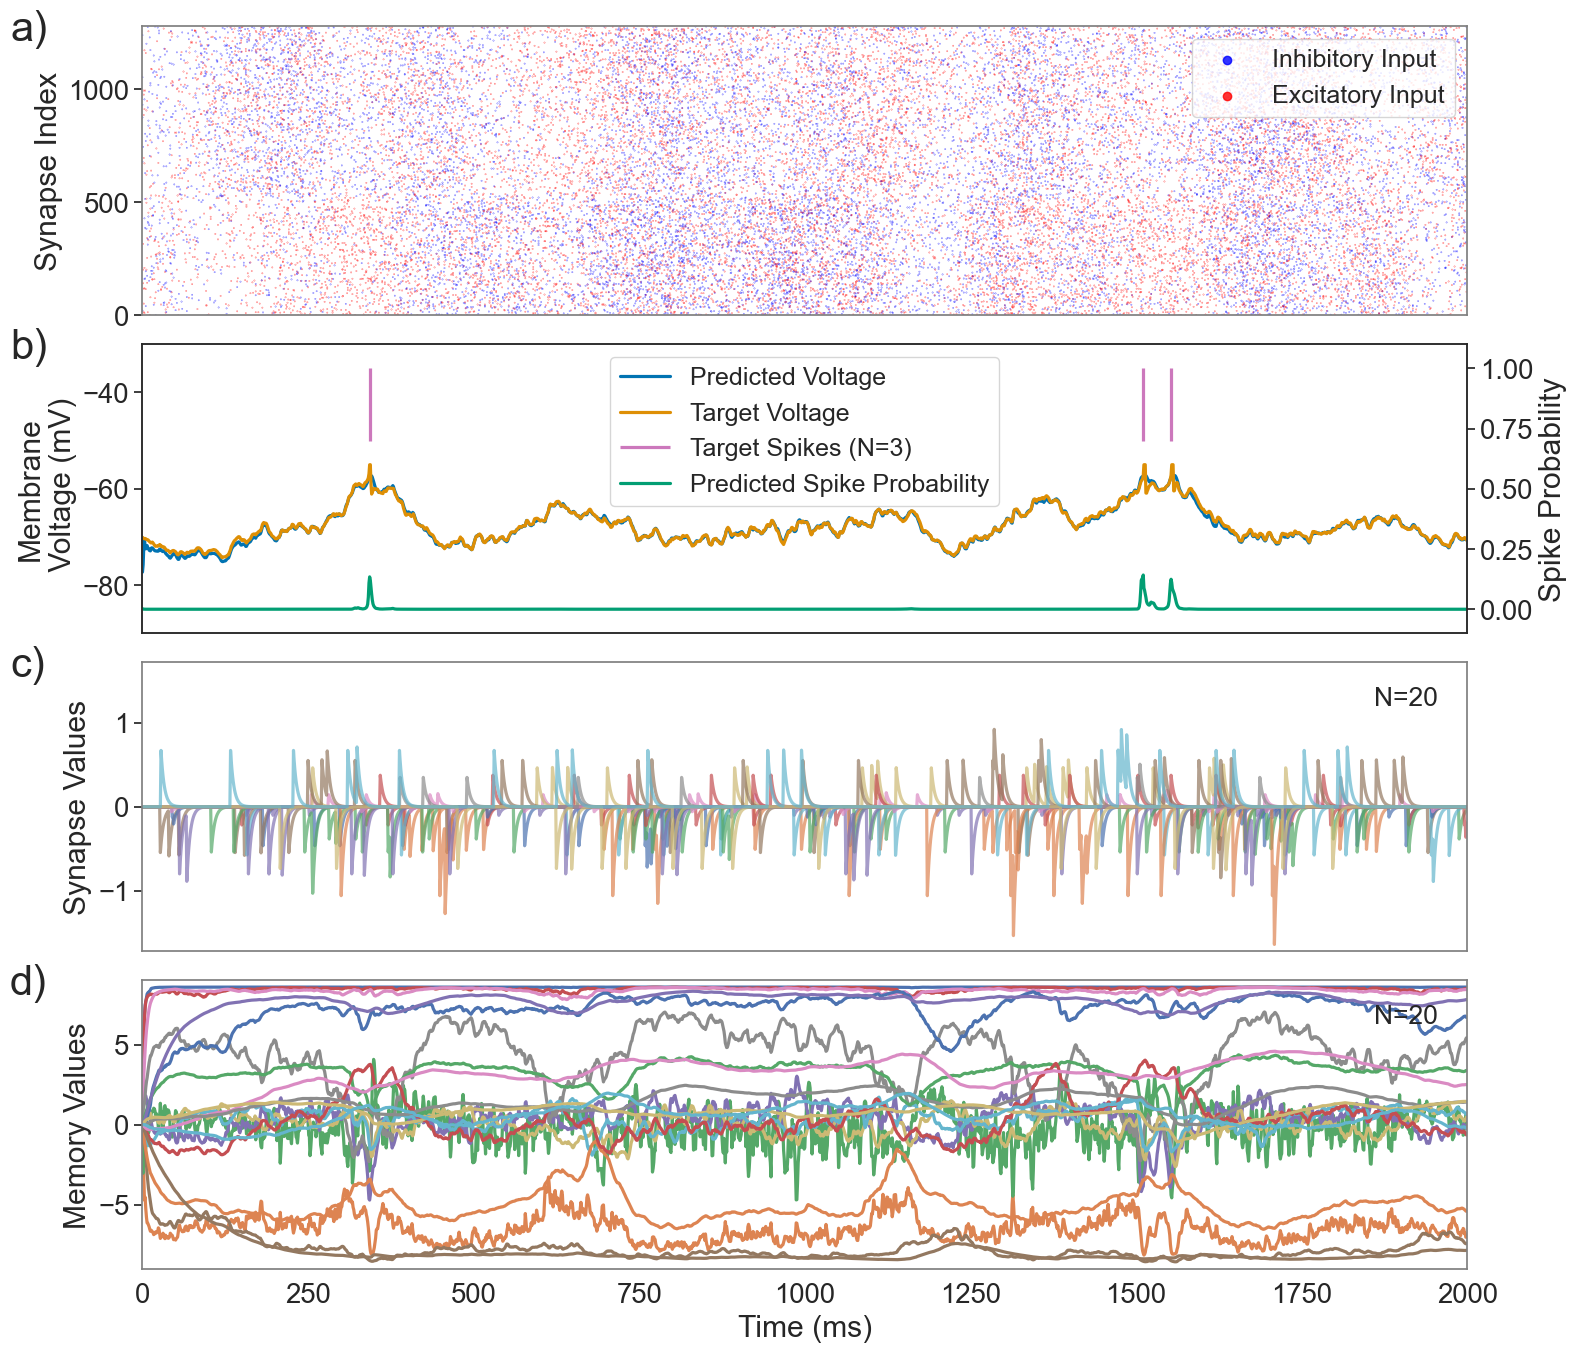

In [12]:
visualize_neuron_workings(
    neuron=model,
    input_spikes=viz_X,
    target_spikes=viz_y_spike,
    target_soma=viz_y_soma,
    color_by_memory_tau=False
)

## Evaluation

In [13]:
# Gather all evaluation metrics
with torch.no_grad():
    if general_config["train_valid_eval"]:
        random.seed(general_config["seed"])
        select_train_files = random.choices(train_files, k=10)
        train_predictions = compute_test_predictions_multiple_sim_files(
            neuron=model,
            test_files=select_train_files,
            burn_in_time=train_config["burn_in_time"],
            input_window_size=train_config["input_window_size"],
            device=torch_device,
        )
        train_results = filter_and_extract_core_results(*train_predictions, verbose=False)

        valid_predictions = compute_test_predictions_multiple_sim_files(
            neuron=model,
            test_files=valid_files,
            burn_in_time=train_config["burn_in_time"],
            input_window_size=train_config["input_window_size"],
            device=torch_device,
        )
        valid_results = filter_and_extract_core_results(*valid_predictions, verbose=False)

    test_predictions = compute_test_predictions_multiple_sim_files(
        neuron=model,
        test_files=test_files,
        burn_in_time=train_config["burn_in_time"],
        input_window_size=train_config["input_window_size"],
        device=torch_device,
    )
    test_results = filter_and_extract_core_results(*test_predictions, verbose=False)

eval_results = dict()
if general_config["train_valid_eval"]:
    eval_results["train_results"] = train_results
    eval_results["valid_results"] = valid_results
eval_results["test_results"] = test_results

In [14]:
# Show evaluation results
eval_results

{'test_results': {'TP @ 0.0025 FP': 0.34591774094536526,
  'AUC @ 0.0025 FP': 0.20212707182320439,
  'TP @ 0.0100 FP': 0.7443216697360344,
  'AUC @ 0.0100 FP': 0.4828077041129528,
  'AUC': 0.9921568143099547,
  'soma_explained_variance_percent': 95.67726778920456,
  'soma_RMSE': 0.6375671096860115,
  'soma_MAE': 0.341511864031163}}